<a href="https://colab.research.google.com/github/SakshiMore22/Agastya/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -r 'requirements.txt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.9/103.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [480]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import os

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Flatten, Conv1D, MaxPooling1D, SimpleRNN, GRU, LSTM, LSTM, Input, Embedding, TimeDistributed, Flatten, Dropout,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [481]:
path_to_json = '/content/Dataset/output.json'
path_to_dumps = '/content/Dumps'
with open(path_to_json) as file:
  data = json.load(file)

In [482]:
def frame_data(label1,label2,is_pattern, data):
  is_pattern = is_pattern
  df = pd.DataFrame(columns=[label1,label2])

  for intent in data['intents']:
    if is_pattern:
      for pattern in intent['patterns']:
        w = pattern
        data_to_append = {label1:w, label2:intent['tags']}
        df.loc[len(df)] = data_to_append

    else:
      for response in intent['responses']:
        w = response
        data_to_append = {label1:w, label2:intent['tags']}
        df.loc[len(df)] = data_to_append
  return df

In [483]:
df1 = frame_data('questions','labels',True, data)
df1.head()

,questions,labels
0,Hi,greetings
1,Hello,greetings
2,Whats up,greetings
3,How are you?,greetings
4,Hi Chatbot,greetings


In [484]:
df1.labels.value_counts(sort=False)

greetings           20
Good morning         2
Good afternoon       2
Good evening         2
Good night           2
goodbye              7
name                 5
thanks               5
neutral-response     2
about                8
skill                2
creation             3
happy               14
casual              22
help                 7
sad                 10
stressed             5
worthless            5
depressed            4
anxious              2
not-talking          4
sleep                6
scared               4
death                6
Name: labels, dtype: int64

In [485]:
df2 = frame_data('response','labels',False, data)
df2.head()

,response,labels
0,Hi there. How are you feeling today?,greetings
1,Good morning. I hope you had a good night's sl...,Good morning
2,Good afternoon. How is your day going?,Good afternoon
3,Good evening. How has your day been?,Good evening
4,Good night. Sweet dreams.,Good night


In [486]:
lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,path_to_dumps+'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return

In [487]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)
        vocab.update(tokens)
    joblib.dump(vocab, path_to_dumps+'vocab.pkl')
    return

In [488]:
create_vocab(tokenizer,df1,'questions')

In [489]:
vocab

Counter({'hi': 5,
         'hello': 4,
         'whats': 3,
         'up': 3,
         'how': 3,
         'are': 5,
         'you': 18,
         'chatbot': 5,
         'hey': 2,
         'is': 4,
         'anyone': 2,
         'there': 3,
         'howdy': 1,
         'hola': 1,
         'bonjour': 1,
         'konnichiwa': 1,
         'guten': 1,
         'tag': 1,
         'ola': 1,
         'good': 9,
         'morning': 1,
         'gm': 1,
         'afternoon': 1,
         'aft': 1,
         'evening': 1,
         'eve': 1,
         'night': 1,
         'gn': 1,
         'see': 5,
         'again': 1,
         'later': 3,
         'im': 8,
         'leaving': 1,
         'have': 5,
         'day': 4,
         'nice': 3,
         'talk': 2,
         'to': 6,
         'what': 8,
         'your': 5,
         'name': 6,
         'thanks': 2,
         'thank': 1,
         'thats': 1,
         'helpful': 1,
         'for': 6,
         'the': 3,
         'help': 4,
         'than': 1,
  

In [490]:
vocab_size = len(vocab)
vocab_size

159

In [491]:
df1.groupby(by='labels',as_index=False).first()['questions']

0                     Good afternoon
1                       Good evening
2                       Good morning
3                         Good night
4                       Who are you?
5                 I feel so anxious.
6                          Oh I see.
7                   Who created you?
8                        My mom died
9            I can't take it anymore
10                     See you again
11                                Hi
12               I feel great today.
13                Could you help me?
14                What is your name?
15                      nothing much
16    I don't want to talk about it.
17               I am feeling lonely
18                        I'm scared
19                  What can you do?
20                   I have insomnia
21              I am so stressed out
22                            Thanks
23              I feel so worthless.
Name: questions, dtype: object

In [492]:
# test_list contains the first element of questions

test_list = list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list


['Good afternoon',
 'Good evening',
 'Good morning',
 'Good night',
 'Who are you?',
 'I feel so anxious.',
 'Oh I see.',
 'Who created you?',
 'My mom died',
 "I can't take it anymore",
 'See you again',
 'Hi',
 'I feel great today.',
 'Could you help me?',
 'What is your name?',
 'nothing much',
 "I don't want to talk about it.",
 'I am feeling lonely',
 "I'm scared",
 'What can you do?',
 'I have insomnia',
 'I am so stressed out',
 'Thanks',
 'I feel so worthless.']

In [493]:
test_index = []
for i,_ in enumerate(test_list):
    idx = df1[df1.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index


[22,
 24,
 20,
 26,
 44,
 127,
 64,
 54,
 143,
 105,
 28,
 0,
 57,
 78,
 35,
 42,
 129,
 85,
 139,
 52,
 133,
 95,
 37,
 100]

In [494]:
train_index = [i for i in df1.index if i not in test_index]
train_index

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 21,
 23,
 25,
 27,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 38,
 39,
 40,
 41,
 43,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 53,
 55,
 56,
 58,
 59,
 60,
 61,
 62,
 63,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 79,
 80,
 81,
 82,
 83,
 84,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 96,
 97,
 98,
 99,
 101,
 102,
 103,
 104,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 128,
 130,
 131,
 132,
 134,
 135,
 136,
 137,
 138,
 140,
 141,
 142,
 144,
 145,
 146,
 147,
 148]

In [495]:
y_train[0]

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [496]:
y_test[0]

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [497]:
len(test_index)

24

In [498]:
def convert_seq(df,feature):
#     text = ' '.join(list(vocab.keys()))
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    print(entries)
    print('----')
    t.fit_on_texts(entries)
    joblib.dump(t, path_to_dumps+'tokenizer_t.pkl')   # why a pkl file
    vocab_size = len(t.word_index) +1 # +1 for oov
    print(t.word_index)
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    print('----')
    print("max length of string is : ",max_length)
    print('----')
    encoded = t.texts_to_sequences(entries)
    print(encoded)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    print('----')
    print(padded)
    return padded, vocab_size

In [499]:
X,vocab_size = convert_seq(df1,'questions')

['Hi', 'Hello', 'Whats up', 'How are you?', 'Hi Chatbot', 'hi chatbot', 'Hi chatbot', 'Hello chatbot', 'Hello Chatbot', 'Hey', 'Is anyone there?', 'Hi there', 'Hello', 'Hey there', 'Howdy', 'Hola', 'Bonjour', 'Konnichiwa', 'Guten tag', 'Ola', 'Good morning', 'Gm', 'Good afternoon', 'Good aft', 'Good evening', 'Good eve', 'Good night', 'Gn', 'See you again', 'See you later', 'Im leaving', 'Have a Good Day', 'Have a nice day', 'Talk to you later', 'See you later', 'What is your name?', 'Whats your name?', 'Thanks', 'Thank you', "That's helpful", 'Thanks for the help', 'Than you very much', 'nothing much', 'for no reason', 'Who are you?', 'What are you?', 'Who you are?', 'Tell me more about yourself.', 'What is your name?', 'What should I call you?', "What's your name?", 'Tell me about yourself', 'What can you do?', 'What are your abilities', 'Who created you?', 'How were you made?', 'How were you created?', 'I feel great today.', 'I am happy.', 'I feel happy.', "I'm good.", 'cheerful', "

In [500]:
with open(path_to_dumps+'tokenizer_t.pkl', 'rb') as f:
    data = pickle.load(f)

In [501]:
data.index_word

{1: 'i',
 2: 'you',
 3: 'feel',
 4: 'am',
 5: 'so',
 6: 'good',
 7: 'what',
 8: 'me',
 9: "i'm",
 10: 'my',
 11: 'to',
 12: 'name',
 13: 'for',
 14: 'no',
 15: 'hi',
 16: 'are',
 17: 'chatbot',
 18: 'see',
 19: 'have',
 20: 'your',
 21: 'do',
 22: "can't",
 23: 'hello',
 24: 'is',
 25: 'help',
 26: 'happy',
 27: 'fine',
 28: 'ok',
 29: 'away',
 30: 'up',
 31: 'how',
 32: 'there',
 33: 'later',
 34: 'a',
 35: 'nice',
 36: 'the',
 37: 'who',
 38: 'about',
 39: 'can',
 40: 'lonely',
 41: "don't",
 42: 'stressed',
 43: 'sleep',
 44: 'died',
 45: 'passed',
 46: 'whats',
 47: 'hey',
 48: 'anyone',
 49: 'day',
 50: 'talk',
 51: 'thanks',
 52: 'much',
 53: 'nothing',
 54: 'tell',
 55: 'yourself',
 56: 'created',
 57: 'were',
 58: 'great',
 59: 'today',
 60: 'cheerful',
 61: 'oh',
 62: 'okay',
 63: 'whatever',
 64: 'k',
 65: 'yeah',
 66: 'yes',
 67: 'not',
 68: 'really',
 69: 'go',
 70: 'please',
 71: 'need',
 72: 'support',
 73: 'sad',
 74: 'out',
 75: 'anymore',
 76: 'it',
 77: 'depressed',
 

In [502]:
data.word_counts

OrderedDict([('hi', 5),
             ('hello', 4),
             ('whats', 2),
             ('up', 3),
             ('how', 3),
             ('are', 5),
             ('you', 18),
             ('chatbot', 5),
             ('hey', 2),
             ('is', 4),
             ('anyone', 2),
             ('there', 3),
             ('howdy', 1),
             ('hola', 1),
             ('bonjour', 1),
             ('konnichiwa', 1),
             ('guten', 1),
             ('tag', 1),
             ('ola', 1),
             ('good', 9),
             ('morning', 1),
             ('gm', 1),
             ('afternoon', 1),
             ('aft', 1),
             ('evening', 1),
             ('eve', 1),
             ('night', 1),
             ('gn', 1),
             ('see', 5),
             ('again', 1),
             ('later', 3),
             ('im', 1),
             ('leaving', 1),
             ('have', 5),
             ('a', 3),
             ('day', 2),
             ('nice', 3),
             ('talk', 2),


In [503]:
vocab_size

166

In [504]:
df_encoded = pd.DataFrame(X)
df_encoded

,0,1,2,3,4,5,6,7,8,9
0,15,0,0,0,0,0,0,0,0,0
1,23,0,0,0,0,0,0,0,0,0
2,46,30,0,0,0,0,0,0,0,0
3,31,16,2,0,0,0,0,0,0,0
4,15,17,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
144,10,159,44,0,0,0,0,0,0,0
145,10,160,45,29,0,0,0,0,0,0
146,10,161,45,29,0,0,0,0,0,0
147,162,163,10,164,44,0,0,0,0,0


In [505]:
df1.head(10)

,questions,labels
0,Hi,greetings
1,Hello,greetings
2,Whats up,greetings
3,How are you?,greetings
4,Hi Chatbot,greetings
5,hi chatbot,greetings
6,Hi chatbot,greetings
7,Hello chatbot,greetings
8,Hello Chatbot,greetings
9,Hey,greetings


In [506]:
df_encoded['labels'] = df1.labels
df_encoded.head(10)

,0,1,2,3,4,5,6,7,8,9,labels
0,15,0,0,0,0,0,0,0,0,0,greetings
1,23,0,0,0,0,0,0,0,0,0,greetings
2,46,30,0,0,0,0,0,0,0,0,greetings
3,31,16,2,0,0,0,0,0,0,0,greetings
4,15,17,0,0,0,0,0,0,0,0,greetings
5,15,17,0,0,0,0,0,0,0,0,greetings
6,15,17,0,0,0,0,0,0,0,0,greetings
7,23,17,0,0,0,0,0,0,0,0,greetings
8,23,17,0,0,0,0,0,0,0,0,greetings
9,47,0,0,0,0,0,0,0,0,0,greetings


In [507]:
df_encoded

,0,1,2,3,4,5,6,7,8,9,labels
0,15,0,0,0,0,0,0,0,0,0,greetings
1,23,0,0,0,0,0,0,0,0,0,greetings
2,46,30,0,0,0,0,0,0,0,0,greetings
3,31,16,2,0,0,0,0,0,0,0,greetings
4,15,17,0,0,0,0,0,0,0,0,greetings
...,...,...,...,...,...,...,...,...,...,...,...
144,10,159,44,0,0,0,0,0,0,0,death
145,10,160,45,29,0,0,0,0,0,0,death
146,10,161,45,29,0,0,0,0,0,0,death
147,162,163,10,164,44,0,0,0,0,0,death


In [508]:
lable_enc = LabelEncoder()

# encoding the labels

labl = lable_enc.fit_transform(df_encoded.labels)
print(labl)
len(labl)

[11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11  2  2  0  0
  1  1  3  3 10 10 10 10 10 10 10 14 14 22 22 22 22 22 15 15  4  4  4  4
  4  4  4  4 19 19  7  7  7 12 12 12 12 12 12 12  6  6  6  6  6  6  6  6
  6  6  6 14 14 14 13 13 13 13 13 13 13 17 17 17 17 17 17 17 17 17 17 21
 21 21 21 21 23 23 23 23 23  9  9  9  9 12 12 12 12 12 12 12  6  6  6  6
  6  6  6  6  6  6  6  5  5 16 16 16 16 20 20 20 20 20 20 18 18 18 18  8
  8  8  8  8  8]


149

In [509]:
mapper = {}
for index,key in enumerate(df_encoded.labels):
    # print(index,key)
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'greetings': 11,
 'Good morning': 2,
 'Good afternoon': 0,
 'Good evening': 1,
 'Good night': 3,
 'goodbye': 10,
 'name': 14,
 'thanks': 22,
 'neutral-response': 15,
 'about': 4,
 'skill': 19,
 'creation': 7,
 'happy': 12,
 'casual': 6,
 'help': 13,
 'sad': 17,
 'stressed': 21,
 'worthless': 23,
 'depressed': 9,
 'anxious': 5,
 'not-talking': 16,
 'sleep': 20,
 'scared': 18,
 'death': 8}

In [510]:
df2.head(10)


,response,labels
0,Hi there. How are you feeling today?,greetings
1,Good morning. I hope you had a good night's sl...,Good morning
2,Good afternoon. How is your day going?,Good afternoon
3,Good evening. How has your day been?,Good evening
4,Good night. Sweet dreams.,Good night
5,Goodbye ! Have a Nice Day,goodbye
6,My name is Aagastya,name
7,"Any time!, I'll always be there",thanks
8,Oh I see. Do you want to talk about something?,neutral-response
9,"I'm Agastya, a Therapeutic AI Assitant designe...",about


In [511]:
na_entries = df2[df2['labels'].isna()]

# Display the entries with NaN values
# print("Entries with NaN values:")
print(len(na_entries))

0


In [512]:
df2.labels = df2.labels.map(mapper).astype('int32')
df2.head()

,response,labels
0,Hi there. How are you feeling today?,11
1,Good morning. I hope you had a good night's sl...,2
2,Good afternoon. How is your day going?,0
3,Good evening. How has your day been?,1
4,Good night. Sweet dreams.,3


In [513]:
df2

,response,labels
0,Hi there. How are you feeling today?,11
1,Good morning. I hope you had a good night's sl...,2
2,Good afternoon. How is your day going?,0
3,Good evening. How has your day been?,1
4,Good night. Sweet dreams.,3
5,Goodbye ! Have a Nice Day,10
6,My name is Aagastya,14
7,"Any time!, I'll always be there",22
8,Oh I see. Do you want to talk about something?,15
9,"I'm Agastya, a Therapeutic AI Assitant designe...",4


In [514]:
df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,labels
0,15,0,0,0,0,0,0,0,0,0,greetings
1,23,0,0,0,0,0,0,0,0,0,greetings
2,46,30,0,0,0,0,0,0,0,0,greetings
3,31,16,2,0,0,0,0,0,0,0,greetings
4,15,17,0,0,0,0,0,0,0,0,greetings


In [515]:
print(train_index)
print(test_index)



[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 25, 27, 29, 30, 31, 32, 33, 34, 36, 38, 39, 40, 41, 43, 45, 46, 47, 48, 49, 50, 51, 53, 55, 56, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 130, 131, 132, 134, 135, 136, 137, 138, 140, 141, 142, 144, 145, 146, 147, 148]
[22, 24, 20, 26, 44, 127, 64, 54, 143, 105, 28, 0, 57, 78, 35, 42, 129, 85, 139, 52, 133, 95, 37, 100]


In [516]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]

In [517]:
train

,0,1,2,3,4,5,6,7,8,9,labels
1,23,0,0,0,0,0,0,0,0,0,greetings
2,46,30,0,0,0,0,0,0,0,0,greetings
3,31,16,2,0,0,0,0,0,0,0,greetings
4,15,17,0,0,0,0,0,0,0,0,greetings
5,15,17,0,0,0,0,0,0,0,0,greetings
...,...,...,...,...,...,...,...,...,...,...,...
144,10,159,44,0,0,0,0,0,0,0,death
145,10,160,45,29,0,0,0,0,0,0,death
146,10,161,45,29,0,0,0,0,0,0,death
147,162,163,10,164,44,0,0,0,0,0,death


In [518]:
test

,0,1,2,3,4,5,6,7,8,9,labels
22,6,95,0,0,0,0,0,0,0,0,Good afternoon
24,6,97,0,0,0,0,0,0,0,0,Good evening
20,6,93,0,0,0,0,0,0,0,0,Good morning
26,6,99,0,0,0,0,0,0,0,0,Good night
44,37,16,2,0,0,0,0,0,0,0,about
127,1,3,5,78,0,0,0,0,0,0,anxious
64,61,1,18,0,0,0,0,0,0,0,casual
54,37,56,2,0,0,0,0,0,0,0,creation
143,10,158,44,0,0,0,0,0,0,0,death
105,1,22,135,76,75,0,0,0,0,0,depressed


In [519]:
test.head()

,0,1,2,3,4,5,6,7,8,9,labels
22,6,95,0,0,0,0,0,0,0,0,Good afternoon
24,6,97,0,0,0,0,0,0,0,0,Good evening
20,6,93,0,0,0,0,0,0,0,0,Good morning
26,6,99,0,0,0,0,0,0,0,0,Good night
44,37,16,2,0,0,0,0,0,0,0,about


In [520]:
train.labels.value_counts()

casual              21
greetings           19
happy               13
sad                  9
about                7
goodbye              6
help                 6
death                5
sleep                5
name                 4
thanks               4
stressed             4
worthless            4
depressed            3
scared               3
not-talking          3
creation             2
anxious              1
Good evening         1
Good night           1
Good morning         1
skill                1
neutral-response     1
Good afternoon       1
Name: labels, dtype: int64

In [521]:
test.labels.value_counts()

Good afternoon      1
Good evening        1
thanks              1
stressed            1
sleep               1
skill               1
scared              1
sad                 1
not-talking         1
neutral-response    1
name                1
help                1
happy               1
greetings           1
goodbye             1
depressed           1
death               1
creation            1
casual              1
anxious             1
about               1
Good night          1
Good morning        1
worthless           1
Name: labels, dtype: int64

In [522]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels

In [523]:
y_test[0]

'greetings'

In [524]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9
1,23,0,0,0,0,0,0,0,0,0
2,46,30,0,0,0,0,0,0,0,0
3,31,16,2,0,0,0,0,0,0,0
4,15,17,0,0,0,0,0,0,0,0
5,15,17,0,0,0,0,0,0,0,0


In [525]:
y_train =pd.get_dummies(y_train).astype(bool).values
y_test =pd.get_dummies(y_test).astype(bool).values

In [526]:
y_train

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [527]:
y_test

array([[ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False,

In [528]:
y_train[0].shape,y_test[0].shape

((24,), (24,))

In [529]:
X_train.shape,X_test.shape

((125, 10), (24, 10))

In [530]:
X_test.shape

(24, 10)

In [531]:
X_train.shape

(125, 10)

In [532]:
max_length = X_train.shape[1]
output = len(mapper)

In [533]:
output

24

In [534]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10) #patience : number of epochs with no improvement after which training will be stopped

checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [early_stopping,checkpoint,reduce_lr]

In [552]:
def define_model3(vocab_size, max_length):
    model3 = Sequential()
    model3.add(Embedding(vocab_size,300, input_length=max_length))
    model3.add(LSTM(500))
    model3.add(Dense(24, activation='softmax'))

    model3.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

    # summarize defined model
    model3.summary()
    return model3

In [553]:
model3 = define_model3(vocab_size, max_length)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 10, 300)           49800     
                                                                 
 lstm_15 (LSTM)              (None, 500)               1602000   
                                                                 
 dense_14 (Dense)            (None, 24)                12024     
                                                                 
Total params: 1663824 (6.35 MB)
Trainable params: 1663824 (6.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [554]:
history = model3.fit(X_train, y_train, epochs=50, verbose=1,validation_data=(X_test,y_test))

Epoch 1/50
4/4 [==============================] - 4s 363ms/step - loss: 3.1057 - accuracy: 0.0880 - val_loss: 3.2442 - val_accuracy: 0.0417
Epoch 2/50
4/4 [==============================] - 1s 162ms/step - loss: 2.7521 - accuracy: 0.1280 - val_loss: 3.8860 - val_accuracy: 0.0417
Epoch 3/50
4/4 [==============================] - 1s 145ms/step - loss: 2.6373 - accuracy: 0.1760 - val_loss: 3.4645 - val_accuracy: 0.0417
Epoch 4/50
4/4 [==============================] - 1s 149ms/step - loss: 2.5852 - accuracy: 0.1840 - val_loss: 3.5580 - val_accuracy: 0.0417
Epoch 5/50
4/4 [==============================] - 1s 158ms/step - loss: 2.4352 - accuracy: 0.1840 - val_loss: 3.5569 - val_accuracy: 0.0833
Epoch 6/50
4/4 [==============================] - 1s 142ms/step - loss: 2.2904 - accuracy: 0.2560 - val_loss: 3.3912 - val_accuracy: 0.0000e+00
Epoch 7/50
4/4 [==============================] - 1s 143ms/step - loss: 2.1499 - accuracy: 0.2480 - val_loss: 3.4247 - val_accuracy: 0.0833
Epoch 8/50
4/4 [

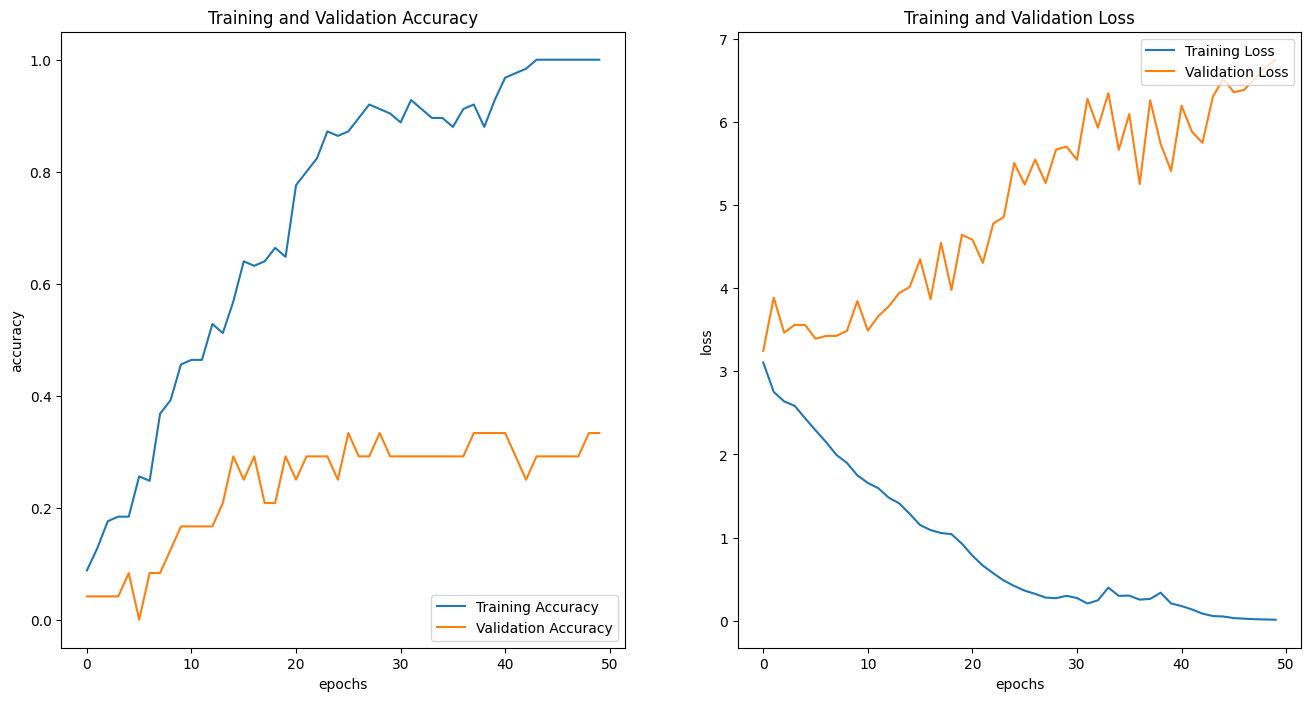

In [555]:
# Learning curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
